# Neural Network Force Fields

A lot of what we do in our group involves the use of what are called "neural network forcefields." These are basically energy and force calculators that are just neural networks that have been trained against some data (be it quantum mechanical/classical/semi-empircal/ect...) It is trained to recreate the potential energy surface

This is little strange, but it will make sense in a second.

In [1]:
!pip install amp-atomistics
!pip install ase

In [2]:
from ase.build import molecule
from ase.calculators.emt import EMT
import numpy as np

atoms = molecule('CO')
atoms.set_calculator(EMT())

distances = np.arange(-0.5,3,0.1)
potential_energies = []


for distance in distances:
    atoms[0].position = [0,0,distance]
    PE = atoms.get_potential_energy()
    potential_energies.append(PE)

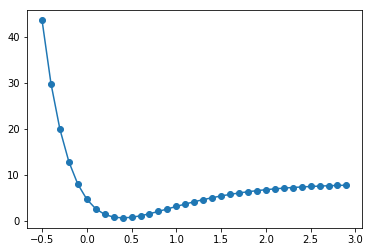

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(distances, potential_energies,'-o')

the chemists and chemical engineers among you may recognize this...

Now let's train a forcefield to replicate this. The code block below is just repeating what we did previously, but saving the images in a list to use as training data.

In [4]:
from ase.io.trajectory import TrajectoryWriter

list_of_atoms = []
list_of_energies = []
tr = TrajectoryWriter('CO.traj')

for distance in distances:
    atoms = molecule('CO')
    atoms.set_calculator(EMT())
    atoms[0].position = [0,0,distance]
    list_of_energies.append(atoms.get_potential_energy())
    atoms.get_forces()
    #tr.write(atoms)
    list_of_atoms.append(atoms)


Now let's train a neural net, we're going to use [amp](https://amp.readthedocs.io/en/latest/useamp.html) (but in the future you will use simple_nn)

In [5]:
from amp import Amp

## The Descriptors

There are two kinds of descriptors: radial ($G_2$) and angular ($G_4$).

$G_{2} = \Sigma_{i \neq j} exp(-\eta (\frac{R_{ij}}{R_{c}})^2)f_C(R_{ij})$

For $G_2$ you can pick the value of $\eta$, the fall off speed and $R_c$, the cutoff distance


$G_{4} = 2^{1-\zeta} \Sigma_i\Sigma_j\Sigma_{k i \neq j \neq k} (1+\gamma cos(\Theta_{jik}))^{\zeta}exp(-\eta \frac{R_{ij}^2 +R_{ik}^2+R_{jk}^2}{R_{c}^2}) f_C(R_{ij})f_c(R_{ij})f_c(R_{ik})f_c(R_{kj})$

For $G_4$ you can pick $\eta$, $\zeta$, $\gamma$, and $R_c$

normally, you punt on the angular values and choose $\gamma = -1,1$ and $\zeta = 1,4$. Notice that this is a three body term

the cutoff function is:

$f_c(R_{ij}) = \frac{1}{2}(1 + cos(\pi \frac{Rij}{Rc}))$



In [6]:
from amp.descriptor.gaussian import Gaussian
from amp.utilities import hash_images

hashes = hash_images(list_of_atoms)
descriptor = Gaussian() #defaults
descriptor.calculate_fingerprints(hashes)
print(descriptor.parameters)

{'importname': '.descriptor.gaussian.Gaussian', 'mode': 'atom-centered', 'version': '2015.12', 'cutoff': {'name': 'Cosine', 'kwargs': {'Rc': 6.5}}, 'Gs': {'C': [{'type': 'G2', 'element': 'C', 'eta': 0.049999999999999996}, {'type': 'G2', 'element': 'O', 'eta': 0.049999999999999996}, {'type': 'G2', 'element': 'C', 'eta': 0.2320794416806389}, {'type': 'G2', 'element': 'O', 'eta': 0.2320794416806389}, {'type': 'G2', 'element': 'C', 'eta': 1.0772173450159415}, {'type': 'G2', 'element': 'O', 'eta': 1.0772173450159415}, {'type': 'G2', 'element': 'C', 'eta': 5.000000000000001}, {'type': 'G2', 'element': 'O', 'eta': 5.000000000000001}, {'type': 'G4', 'elements': ['C', 'C'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['C', 'O'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['O', 'O'], 'eta': 0.005, 'gamma': 1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['C', 'C'], 'eta': 0.005, 'gamma': -1.0, 'zeta': 1.0}, {'type': 'G4', 'elements': ['C', 'O'], '

In [7]:
descriptor.fingerprints['96d61608e3336dd3b0083e0d10d54f5e']

[('O',
  [0.8942579161578427,
   0.0,
   0.8871857996999152,
   0.0,
   0.8550852247863622,
   0.0,
   0.7206426127482876,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('C',
  [0.0,
   0.8942579161578427,
   0.0,
   0.8871857996999152,
   0.0,
   0.8550852247863622,
   0.0,
   0.7206426127482876,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0])]

# The Model

we're going to use a neural network

In [8]:
from amp.model.neuralnetwork import NeuralNetwork

In [9]:
model = NeuralNetwork(hiddenlayers=(5, 5), activation='tanh')

In [10]:
from amp import Amp

calc = Amp(descriptor=descriptor, model=model,
           label='calc')
calc.train(images=list_of_atoms)

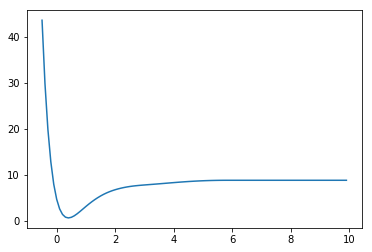

In [14]:
calc = Amp.load('calc.amp')
atoms = molecule('CO')
atoms.set_calculator(calc)

distances = np.arange(-0.5,10,0.1)
NN_potential_energies = []


for distance in distances:
    atoms[0].position = [0,0,distance]
    PE = atoms.get_potential_energy()
    NN_potential_energies.append(PE)

plt.plot(distances, NN_potential_energies,'-')

# The Parity Plot

We want to see how close our predictions are to the correct answer

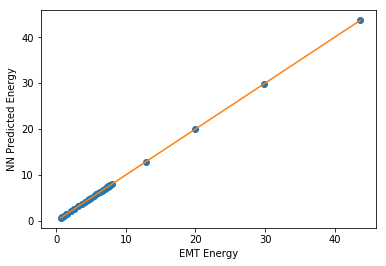

In [12]:
plt.scatter(list_of_energies, NN_potential_energies)

plt.plot(min(list_of_energies), )
plt.ylabel('NN Predicted Energy')
plt.xlabel('EMT Energy')

# make the parity line
combined = list_of_energies + NN_potential_energies
minumum = min(combined)
maximum = max(combined)
plt.plot([minumum, maximum],[minumum, maximum])

# Error Metric

there are many error metrics, here we will look at the root mean square error (RMSE):

$L_{RMSE} = \sqrt{\frac{1}{n}\Sigma_{i=1}^n (E-E_{pred})^2}$

In [13]:
sse = [(a - b) ** 2 for a, b in zip(list_of_energies, NN_potential_energies)]
mse = np.mean(sse)
rmse = np.sqrt(mse)
print(rmse)

0.001977268730990049


In [15]:
from amp import Amp
from ase.io import read

distances = np.arange(-0.5,2,0.1)
angles = np.arange(103,180, 2)
list_of_waters = []
water_energies = []


for distance in distances:
    for angle in angles:
        atoms = molecule('H2O')
        atoms.set_angle(1, 0, 2, angle)
        atoms.set_distance(0, 1,distance, fix=0)
        atoms.set_calculator(EMT())
        water_energies.append(atoms.get_potential_energy())
        atoms.get_forces()
        list_of_waters.append(atoms)

calc = Amp(descriptor=Gaussian(), model=NeuralNetwork(),
           label='calc2')
calc.model.lossfunction.parameters['convergence'].update(
    {'energy_rmse': 0.05,})
calc.train(images=list_of_waters)